In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For ARIMA model
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

# Customized functions to do ARIMA modeling
import functions.crop_by_country_arima_analyses as ca

In [53]:
# %load functions/crop_by_country_arima_analyses.py
# This file read in the trade matrix file, takes input for variables 'item' and 'element',
# pre-process data and select countries with have >50% non-zero data points,
# then train an ARIMA model via gridsearch for each country,
# returns best parameter estimates
# and have options to return plots of mean squared error by countries.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For ARIMA model
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf



# Function for step 1: extract data

def item_element_country(df, years, item, element):
    '''function to take input of an item name, element name (e.g. Export/import value) and
    output a formated file (aggregated by Reporter Countries) for downstream analysis'''

    data = df.loc[(df['Item'] == item) & (df['Element'] == element), :]
    data_50 = data.loc[data['NoneZero'] >= 16, :]
    print('{} country names selected for those with >50% non-zero data'.format(data_50.shape[0]))

    # Reshape data from wide to long by years
    data_long = data_50.melt(['Reporter Countries'], years, 'year', 'value')

    # Convert data to time series
    data_long['year'] = data_long['year'].map(
        lambda x: x.lstrip('Y'))  # strip Y from year names for easy converting to ts
    data_long.year = pd.to_datetime(data_long.year)

    # Reshape data from long to wide, turn countries into columns
    data_wide = data_long.pivot(index='year', columns='Reporter Countries', values='value')

    return data_wide


# Function for step 2: normalize data###
def df_normalize(df_original):
    '''function to transform and normalize crop trade data
    '''
    # calculate 3-year rolling mean to smooth data and add 1 to prep for log transformation
    # Assume that adding 1 tonne per year will not significantly change the time series patterns for any country
    rolled = df_original.rolling(3).mean().add(1)

    # Log-transformation to scale down countries with large numbers
    # Then divide each data point by the third row's value (removed first two rows which are NaNs)
    # So that all countries have the same start point 0
    #df_normalized = np.log(rolled[2:].div(rolled[2:].iloc[0]))
    df_normalized = rolled[2:]
    return df_normalized

# Function for step 3: check stationarity and remove non-stationary countries
def stationarity(df):
    '''function to run A-Dickey-Fuller test on time series for each country,
    return list of countries that passed the test'''
    non_stationary_countries = []

    for country in df.columns:
        stationarity = adfuller(df[country].dropna())

        if stationarity[1] <= 0.05:
            non_stationary_countries.append(country)
        stationary_countries = [i for i in df.columns.tolist() if i not in non_stationary_countries]
    print('There were {} non-stationary countries being removed and\n result in {} stationary countries'.format(
        len(non_stationary_countries),
        len(stationary_countries)))
    return stationary_countries


# Functions for Step 4: Training an ARIMA model for each country and use gridsearch to find best parameters
# ref: https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/
# ref: https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/
# Step 4-1): Evaluate an ARIMA model use MSE


def eval_arima(data, order, split):
    '''function to split a time series into train and test set, build an ARIMA model
      use rolling one-at-a-time predictions, and reture mean squared error of the model'''

    # split dataset into training and testing
    train_size = int(len(data) * split)
    train, test = data[0: train_size], data[train_size:]

    # Make one prediction/forecast at a time, put the prediction into predictions list,
    # then add one data from test set to train set for the next model
    rolling_train = [train_data for train_data in train]
    predictions = []
    for test_data in range(len(test)):
        model = ARIMA(rolling_train, order=order)
        model_fit = model.fit()
        one_prediction = model_fit.forecast()[0]
        predictions.append(one_prediction)
        rolling_train.append(test[test_data])
    predictions = np.squeeze(predictions) # reshape data
    mse = mean_squared_error(test, predictions) # Mean squared error

    mape = np.mean(np.abs(predictions-test)/np.abs(test))  # Mean absolute percentage error

    corr = np.corrcoef(predictions,test)[0,1] # correlation between fitted and test data

    mins = np.amin(np.hstack([predictions[:,None], test[:, None]]), axis=1) # find min values of fitted and test
    maxs = np.amax(np.hstack([predictions[:,None], test[:, None]]), axis=1) # find max values of fitted and test
    minmax = 1 - np.mean(mins/maxs) # Min-max error

    return({'MSE':mse, 'MAPE': mape, 'Corr': corr, 'MinMax': minmax})

# Step 4-2): Grid search for order(p,d,q) of ARIMA model
p_values = [0, 1, 2, 3, 4, 5, 6]
d_values = [0]  # processed data are non-stationary so no need to optimize d value
q_values = [0, 1, 2]
split = 0.7

import warnings
warnings.filterwarnings("ignore")


def gridsearch_arima(data, p_values, d_values, q_values, split):
    best_mse, mape, corr, minmax, best_cfg = float("inf"),float("inf"),float("inf"),float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                split = split
                try:
                    metrics = eval_arima(data, order, split)
                    if metrics['MSE'] < best_mse: # Use MSE as accuracy metric
                        best_mse, mape, corr, minmax, best_cfg = metrics['MSE'], metrics['MAPE'], metrics['Corr'], metrics['MinMax'], order
                except:
                    continue
    print(data.name, best_cfg, 'MSE=%.2E' % best_mse)
    return data.name, best_cfg, best_mse, mape, corr, minmax


# Step 4-3): Loop through all countries to make predictions
def countries_arima(data):
    results = []
    for country in data.columns:
        country_result = gridsearch_arima(data[country], p_values, d_values, q_values, split)
        results.append(country_result)
    results = pd.DataFrame(results, columns=['country', 'best_arima', 'mse','mape','corr','minmax'])
    return results

########################################################################

# Putting all together:

# Function 1: data preprocessing and visualization
def crop_country_preprocess(data, years, item, element, plot=True):
    '''function to conduct crop-by-country arima analysis'''

    # step 1 : extract data
    df_original = item_element_country(data, years, item, element)

    # step 2 : normalize data
    df_normalized = df_normalize(df_original)

    # Step 3: check stationarity and remove non-stationary countries
    stationary_countries = stationarity(df_normalized) # Check stationarity

    df_processed = df_normalized[stationary_countries] # Remove non-stationary countries from data frame

    # Plotting 1
    if plot==True:
        # Visually compare original data and normalized data
        fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15, 5))
        ax1.plot(df_original)
        ax2.plot(df_normalized)

        ax1.set_title('original')
        ax1.set_ylabel('tonnes')
        ax2.set_title('Three-year Average')

        fig.suptitle('Annual {} {} by Countries'.format(item, element))
        plt.show()

        import warnings
        warnings.filterwarnings("ignore")

    return df_original, df_processed

# Function 2: ARIMA modeling

def crop_country_arima(df_processed, item, element, plot=True):
    '''function to conduct crop-by-country arima analysis'''

    # Step 5 Training an ARIMA model for each country and use gridsearch to find best parameters
    df_arima = countries_arima(df_processed)

    # Save results
    df_arima = df_arima.set_index('country')
    df_arima.to_csv('../data/processed/arima_{}_{}_.csv'.format(item, element))

    # Plotting 2: MSE
    # ref: https://matplotlib.org/3.1.0/gallery/subplots_axes_and_figures/subplots_demo.html
    if plot == True:
        df_arima = df_arima.sort_values(by='mse')
        fig, axs = plt.subplots(2, 2, figsize=(20, 12))

        axs[0, 0].plot(df_arima['mse'])
        axs[0, 0].set_title('Mean Squared Error')
        axs[0, 1].plot(df_arima['mape'])
        axs[0, 1].set_title('Mean Absolute Percentage Error')
        axs[1, 0].plot(df_arima['corr'])
        axs[1, 0].set_title('Correlation between predictions and test data')
        axs[1, 1].plot(df_arima['minmax'])
        axs[1, 1].set_title('Min-Max Error')
        plt.xticks(fontsize=12, rotation=90)
        plt.yticks(fontsize=14)
        plt.show()

    return df_arima


# Function 3: ARIMA forecasting for each country using best parameters


def crop_country_forecast(df_processed, df_arima, n_periods=8):
    index = pd.date_range(start='1988', end='2025', freq='AS-JAN')
    index_future = pd.date_range(start='2018', end='2025', freq='AS-JAN')

    forecast_values = pd.DataFrame(index=index)
    lower_ci_values = pd.DataFrame()
    upper_ci_values = pd.DataFrame()

    for country in df_processed.columns:
        processed = df_processed[country]

        try:
            model = ARIMA(processed, order=df_arima.loc[country][0])
            model_fit = model.fit()

            # forecast 8 years into the future -- 2025
            forecast = model_fit.predict(start='1988', end='2025')
            forecast.name = country
            

            # Get confidence intervals
            lower_ci = pd.Series(model_fit.forecast(n_periods)[2][:, 0])
            lower_ci.name = country
            upper_ci = pd.Series(model_fit.forecast(n_periods)[2][:, 1])
            upper_ci.name = country

            forecast_values = pd.concat([forecast_values, pd.DataFrame(forecast)], axis=1)
            lower_ci_values = pd.concat([lower_ci_values, pd.DataFrame(lower_ci)], axis=1)
            upper_ci_values = pd.concat([upper_ci_values, pd.DataFrame(upper_ci)], axis=1)
            print('{} fitted'.format(country))

        except:
            continue

    lower_ci_values = lower_ci_values.set_index(index_future)
    upper_ci_values = upper_ci_values.set_index(index_future)

    return forecast_values, lower_ci_values, upper_ci_values



In [21]:
# Read in processed data
items_by_country = pd.read_csv('../data/processed/items_by_country.csv',index_col=0)
print(items_by_country.shape)

# Put name for years into a column
# The years list is used by the function below when reshaping data frame 
year = items_by_country.columns[5:-1].tolist() # Select year 1986-2017

(223049, 38)


In [3]:
items_by_country.head()

,Reporter Countries,Item,Element,Unit,Item Code,Y1986,Y1987,Y1988,Y1989,Y1990,...,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017,NoneZero
0,Afghanistan,Almonds shelled,Export Quantity,tonnes,5313,0.0,0.0,0.0,0.0,0.0,...,4763.0,1308.0,2261.0,0.0,0.0,2714.0,2086.0,1778.0,2756.0,7
1,Afghanistan,Almonds shelled,Export Value,1000 US$,5313,0.0,0.0,0.0,0.0,0.0,...,35476.0,15894.0,20270.0,0.0,0.0,16454.0,12793.0,10934.0,19677.0,7
2,Afghanistan,Almonds shelled,Import Quantity,tonnes,1617,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,168.0,181.0,846.0,103.0,4
3,Afghanistan,Almonds shelled,Import Value,1000 US$,1617,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1117.0,1377.0,4988.0,759.0,4
4,Afghanistan,"Almonds, with shell",Export Quantity,tonnes,3315,0.0,0.0,0.0,0.0,0.0,...,11066.0,779.0,1016.0,0.0,0.0,1856.0,1660.0,1545.0,875.0,7


From previous analysis (2_exploratory-analysis-agtrade.ipynb),top five exported crops between 1986 and 2017 in quantities (tonnes) are:   
Wheat, Maize, Soybeans, Barley and Rice - total  (Rice milled equivalent)  

We shall build an ARIMA model for each crop of every exporting country, and forecast export into 2025.

### 1. ARIMA modeling for top-five export crops in total quantity between 1986 and 2017

In [4]:
# Get data for the export value of wheat
# Assign variables
item = 'Maize'
element = 'Export Quantity' # or Export/Import Value
data = items_by_country.copy()
years = year
unit = 'tonnes' # 1000 US$ for value

95 country names selected for those with >50% non-zero data
There were 17 non-stationary countries being removed and
 result in 78 stationary countries


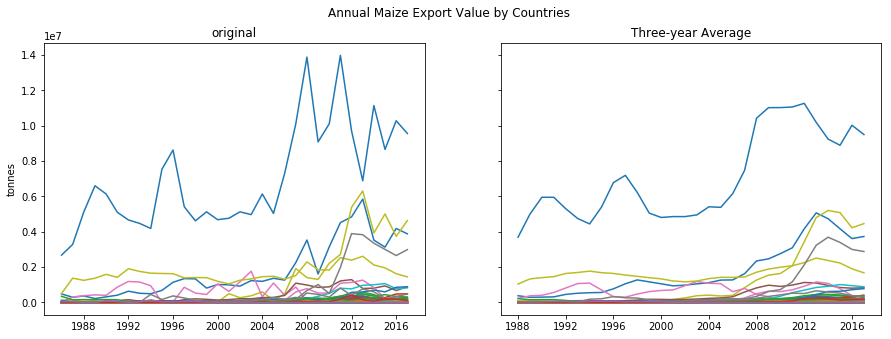

In [6]:
df = ca.crop_country_preprocess(data, years, item, element, plot=True)

df_original = df[0]
df_processed = df[1]

Argentina (1, 0, 0) MSE=3.28E+11
Australia (1, 0, 0) MSE=4.51E+07
Austria (3, 0, 0) MSE=3.99E+08
Barbados (1, 0, 0) MSE=7.15E+00
Belgium (1, 0, 0) MSE=4.38E+08
Benin (1, 0, 0) MSE=4.00E+06
Bolivia (Plurinational State of) (2, 0, 0) MSE=3.54E+06
Brazil (1, 0, 0) MSE=5.65E+11
Bulgaria (1, 0, 0) MSE=3.76E+09
Burkina Faso (3, 0, 0) MSE=2.11E+06
Cameroon (0, 0, 2) MSE=2.21E+04
Chile (2, 0, 0) MSE=1.54E+09
China, Taiwan Province of (1, 0, 0) MSE=4.27E+04
China, mainland (3, 0, 2) MSE=2.60E+10
Colombia (1, 0, 0) MSE=9.57E+06
Croatia (5, 0, 0) MSE=7.72E+07
Czechia (1, 0, 0) MSE=2.55E+08
Côte d'Ivoire (1, 0, 0) MSE=1.96E+06
Denmark (1, 0, 0) MSE=1.16E+07
Ecuador (1, 0, 1) MSE=8.04E+05
Egypt (0, 0, 2) MSE=1.47E+06
El Salvador (0, 0, 2) MSE=4.93E+05
Estonia (1, 0, 0) MSE=6.34E+04
Finland (1, 0, 0) MSE=1.92E+00
Georgia (1, 0, 0) MSE=4.55E+06
Germany (3, 0, 0) MSE=8.73E+08
Ghana (1, 0, 0) MSE=2.84E+06
Greece (1, 0, 0) MSE=3.12E+07
Honduras (2, 0, 0) MSE=6.44E+05
Hungary (1, 0, 0) MSE=1.05E+10
Irela

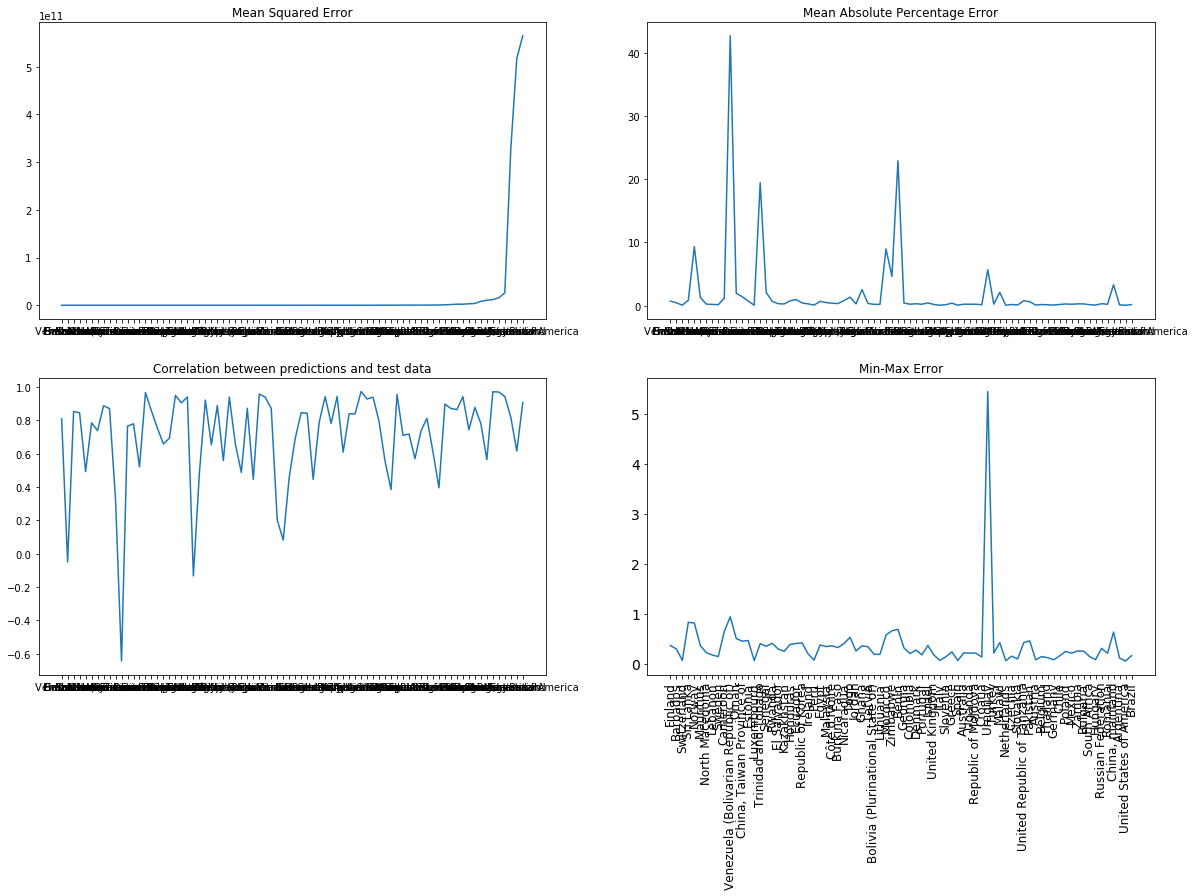

In [8]:
df_arima = ca.crop_country_arima(df_processed, item, element, plot=True)

In [82]:
df_arima['Uganda']

KeyError: 'Uganda'

In [54]:
maize_forecast = crop_country_forecast(df_processed, df_arima)

Argentina fitted
Australia fitted
Austria fitted
Barbados fitted
Belgium fitted
Benin fitted
Bolivia (Plurinational State of) fitted
Brazil fitted
Bulgaria fitted
Burkina Faso fitted
Cameroon fitted
Chile fitted
China, Taiwan Province of fitted
China, mainland fitted
Colombia fitted
Croatia fitted
Czechia fitted
Côte d'Ivoire fitted
Denmark fitted
Ecuador fitted
Egypt fitted
El Salvador fitted
Estonia fitted
Finland fitted
Georgia fitted
Germany fitted
Ghana fitted
Greece fitted
Honduras fitted
Hungary fitted
Ireland fitted
Israel fitted
Italy fitted
Jordan fitted
Kazakhstan fitted
Latvia fitted
Lebanon fitted
Lithuania fitted
Luxembourg fitted
Malawi fitted
Malaysia fitted
Mauritius fitted
Mexico fitted
Morocco fitted
Netherlands fitted
Nicaragua fitted
North Macedonia fitted
Norway fitted
Oman fitted
Pakistan fitted
Peru fitted
Poland fitted
Portugal fitted
Republic of Korea fitted
Republic of Moldova fitted
Romania fitted
Russian Federation fitted
Rwanda fitted
Senegal fitted
Slovak

In [112]:
forecast_values= maize_forecast[0]
lower_ci_values= maize_forecast[1]
upper_ci_values= maize_forecast[2]

In [65]:
set(df_processed.columns)-set(maize_forecast[1].columns)

{'Uganda'}

Text(0.5, 1.0, 'MSE: 1.84E+09')

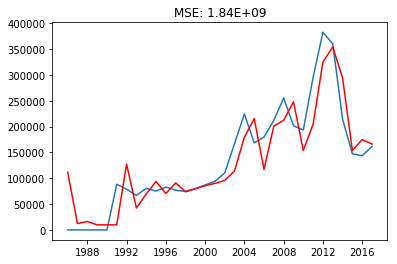

In [98]:
# Build a ARIMA model
# Germany (1, 0, 0) MSE=2.88E-01
original = df_original['Germany']
model = ARIMA(original, order = (3,0,0))
model_fit = model.fit()
plt.plot(original)
plt.plot(model_fit.fittedvalues, color='red')
plt.title('MSE: %.2E'% mean_squared_error(model_fit.fittedvalues,original))

Text(0.5, 1.0, 'MSE: 4.71E+01')

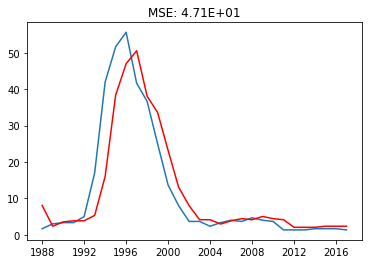

In [99]:
# Build a ARIMA model
# Germany (1, 0, 0) MSE=2.88E-01
processed = df_processed['Finland']
model = ARIMA(processed, order = (1,0,0))
processed_fit = model.fit()
plt.plot(processed)
plt.plot(processed_fit.fittedvalues, color='red')
plt.title('MSE: %.2E'% mean_squared_error(processed_fit.fittedvalues,processed))

In [91]:
model = ARIMA(processed, order = (5,0,0))
processed_fit = model.fit()

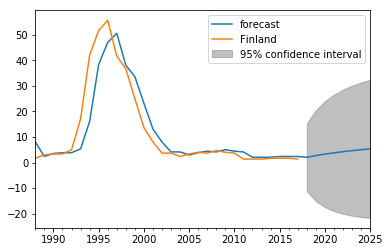

In [100]:
processed_fit.plot_predict(start='1988', end = '2025')
plt.show()

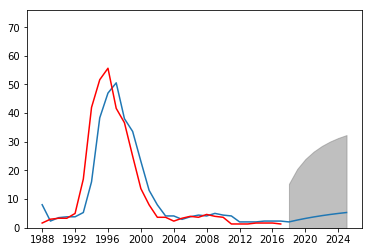

In [111]:
n_periods = 8 # forecast 8 years into the future -- 2025

forecast = processed_fit.predict(start='1988',end='2025')

# Get confidence intervals
lower_ci =  processed_fit.forecast(n_periods)[2][:,0]
upper_ci =  processed_fit.forecast(n_periods)[2][:,1]

# Get date indexes
index = processed_fit.data.predict_dates

plt.plot(forecast)
plt.plot(processed,color='red')
plt.fill_between(index[-n_periods:],
                lower_ci,
                upper_ci, color='gray',alpha=.5)
plt.ylim(0,max(max(upper_ci),max(forecast))*1.5)

plt.show()

In [103]:
lower_ci

array([-11.24102992, -15.12869353, -17.47066212, -19.01816046,
       -20.07881742, -20.81634328, -21.32988855, -21.68421553])

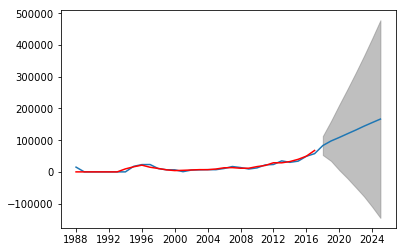

In [92]:
n_periods = 8 # forecast 8 years into the future -- 2025

forecast = processed_fit.predict(start='1988',end='2025')

# Get confidence intervals
lower_ci =  processed_fit.forecast(n_periods)[2][:,0]
upper_ci =  processed_fit.forecast(n_periods)[2][:,1]

# Get date indexes
index = processed_fit.data.predict_dates

plt.plot(forecast)
plt.plot(processed,color='red')
plt.fill_between(index[-n_periods:],
                lower_ci,
                upper_ci, color='gray',alpha=.5)

plt.show()

In [79]:
def gridsearch_arima(data, p_values, d_values, q_values, split):
    best_mse, mape, corr, minmax, best_cfg = float("inf"),float("inf"),float("inf"),float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                split = split
                try:
                    metrics = eval_arima(data, order, split)
                    if metrics['MSE'] < best_mse: # Use MSE as accuracy metric
                        best_mse, mape, corr, minmax, best_cfg = metrics['MSE'], metrics['MAPE'], metrics['Corr'], metrics['MinMax'], order
                    print(order, metrics['MSE'],best_mse)
                except:
                    continue
    print(data.name, best_cfg, 'MSE=%.2E' % best_mse)
    return data.name, best_cfg, best_mse, mape, corr, minmax


In [81]:
eval_arima(df_processed['Uganda'], order=(6,0,0), split=0.7)

{'MSE': 50172836.30016043,
 'MAPE': 0.2161925051194812,
 'Corr': 0.9728314119338297,
 'MinMax': 0.215993666016699}

(0, 0, 0) 750656840.1719278 750656840.1719278
(0, 0, 1) 308509781.56222695 308509781.56222695
(1, 0, 0) 78295943.298851 78295943.298851
(2, 0, 0) 53741708.150629744 53741708.150629744
(3, 0, 0) 55889181.88448718 53741708.150629744
(4, 0, 0) 52376034.0282593 52376034.0282593
(5, 0, 0) 50354999.62255224 50354999.62255224
(6, 0, 0) 50172836.30016043 50172836.30016043
Uganda (6, 0, 0) MSE=5.02E+07


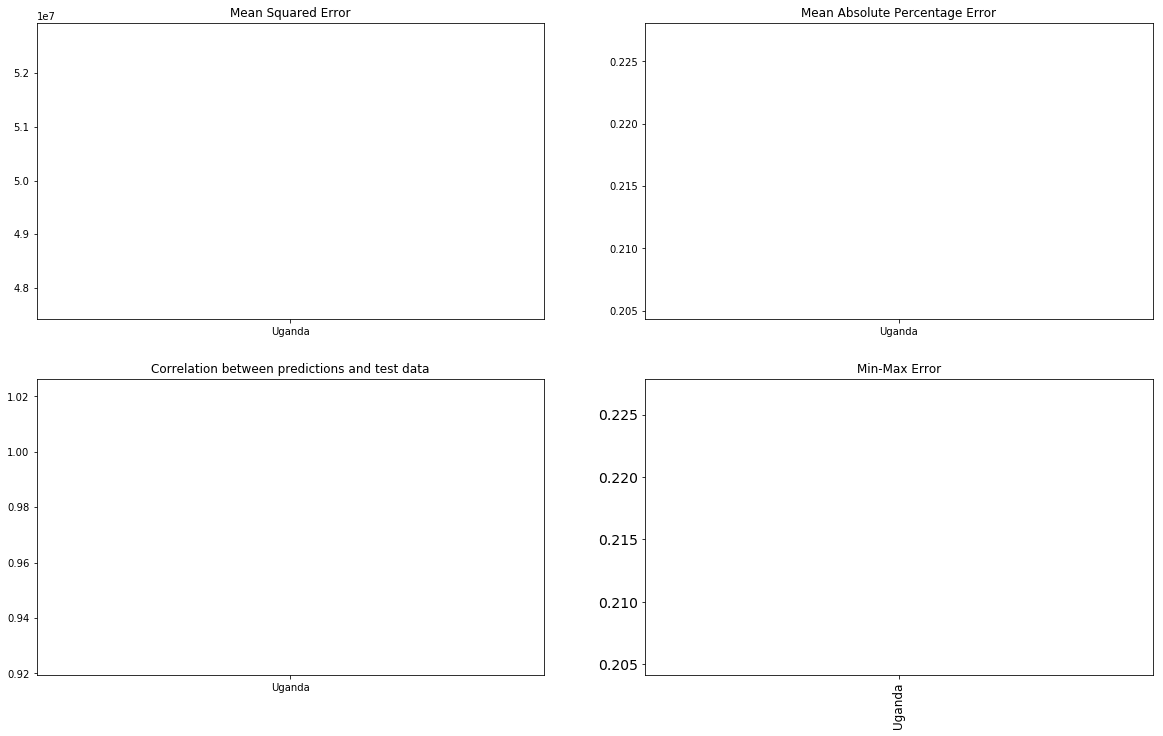

In [80]:
uganda = crop_country_arima(pd.DataFrame(df_processed['Uganda']), item=item, element=element)

In [58]:
df_processed.iloc[:,0].index

DatetimeIndex(['1988-01-01', '1989-01-01', '1990-01-01', '1991-01-01',
               '1992-01-01', '1993-01-01', '1994-01-01', '1995-01-01',
               '1996-01-01', '1997-01-01', '1998-01-01', '1999-01-01',
               '2000-01-01', '2001-01-01', '2002-01-01', '2003-01-01',
               '2004-01-01', '2005-01-01', '2006-01-01', '2007-01-01',
               '2008-01-01', '2009-01-01', '2010-01-01', '2011-01-01',
               '2012-01-01', '2013-01-01', '2014-01-01', '2015-01-01',
               '2016-01-01', '2017-01-01'],
              dtype='datetime64[ns]', name='year', freq=None)

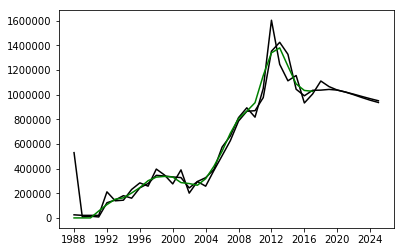

In [23]:

plt.plot(processed_fit.predict(start='1988',end='2025'), color='black')
plt.plot(model_fit.predict(start='1988',end='2025'), color='black')
plt.plot(original.rolling(3).mean().add(1), color='green')

In [119]:
index_future = pd.date_range(start='2018', end='2025', freq='AS-JAN')
index_future

DatetimeIndex(['2018-01-01', '2019-01-01', '2020-01-01', '2021-01-01',
               '2022-01-01', '2023-01-01', '2024-01-01', '2025-01-01'],
              dtype='datetime64[ns]', freq='AS-JAN')

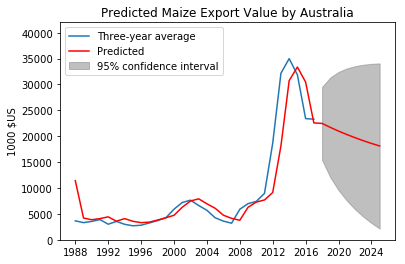

In [139]:
country= 'Australia'
unit = '1000 $US'
fig, ax = plt.subplots()
ax.plot(df_processed[country], label='Three-year average')
ax.plot(forecast_values[country],color='red', label='Predicted')

# Plot CI
ax.fill_between(index_future, lower_ci_values[country],
                upper_ci_values[country], color='gray', alpha=.5, label='95% confidence interval')
ax.set_title('Predicted {} {} by {}'.format(item,element,country))
ax.set_ylabel(unit)
ax.legend()
# set y axis to be begin at 0 and max at 1.2 times of maximum value in the plot
plt.ylim(0,max(max(df_processed[country]),max(forecast_values[country]),max(upper_ci_values[country]))*1.2)

plt.show()

In [130]:
df_processed.columns

Index(['Argentina', 'Australia', 'Austria', 'Barbados', 'Belgium', 'Benin',
       'Bolivia (Plurinational State of)', 'Brazil', 'Bulgaria',
       'Burkina Faso', 'Cameroon', 'Chile', 'China, Taiwan Province of',
       'China, mainland', 'Colombia', 'Croatia', 'Czechia', 'Côte d'Ivoire',
       'Denmark', 'Ecuador', 'Egypt', 'El Salvador', 'Estonia', 'Finland',
       'Georgia', 'Germany', 'Ghana', 'Greece', 'Honduras', 'Hungary',
       'Ireland', 'Israel', 'Italy', 'Jordan', 'Kazakhstan', 'Latvia',
       'Lebanon', 'Lithuania', 'Luxembourg', 'Malawi', 'Malaysia', 'Mauritius',
       'Mexico', 'Morocco', 'Netherlands', 'Nicaragua', 'North Macedonia',
       'Norway', 'Oman', 'Pakistan', 'Peru', 'Poland', 'Portugal',
       'Republic of Korea', 'Republic of Moldova', 'Romania',
       'Russian Federation', 'Rwanda', 'Senegal', 'Slovakia', 'Slovenia',
       'South Africa', 'Spain', 'Sri Lanka', 'Sweden', 'Switzerland',
       'Thailand', 'Togo', 'Trinidad and Tobago', 'Turkey', 'Uga

In [142]:
def plot_forecast(country, df_processed, forecast_values, lower_ci_values, upper_ci_values,
                  item=item,element=element,unit=unit):
    
    '''Function to plot selected country data including 3-year average, predicted and 95% CI'''
    
    fig, ax = plt.subplots()
    ax.plot(df_processed[country], label='Three-year average')
    ax.plot(forecast_values[country], color='red', label='Predicted')

    # Plot CI
    ax.fill_between(index_future, lower_ci_values[country],
                    upper_ci_values[country], color='gray', alpha=.5, label='95% confidence interval')
    ax.set_title('Predicted {} {} by {}'.format(item, element, country))
    ax.set_ylabel(unit)
    ax.legend()
    # set y axis to be begin at 0 and max at 1.2 times of maximum value in the plot
    plt.ylim(0, max(max(df_processed[country]), max(forecast_values[country]), max(upper_ci_values[country])) * 1.2)

    plt.show()

    return fig

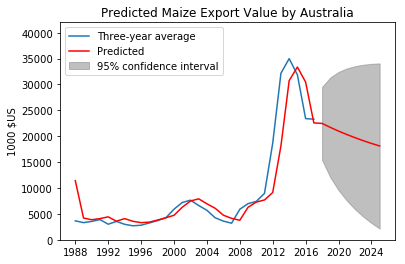

In [143]:
country = 'Australia'
fig = plot_forecast(country, df_processed, forecast_values, lower_ci_values, upper_ci_values,
                  item=item,element=element,unit=unit)